# ```uavsar_pytools``` Tutorial

In this notebook, we will display the basic functionality of using ```asf_search``` to find UAVSAR data products, and ```uavsar_pytools``` convert those products in analysis ready GeoTiifs. UAVSAR files come in a flat binary format, which are not ready for analysis. This package allows for the systematic conversion of binary files into GeoTiffs using information from the UAVSAR annoation file.

In [5]:
import asf_search as asf
from uavsar_pytools.UavsarImage import UavsarImage #single image class
from uavsar_pytools.uavsar_tools import grd_tiff_convert #single image class
from uavsar_pytools.UavsarScene import UavsarScene # binary convert to .tiffs
import os  # for chdir, getcwd, path.basename, path.exists
from datetime import datetime
import progressbar
from tqdm import tqdm
import logging
import glob
import requests
import zipfile
#from uavsar_pytools.convert import convert_image
#from uavsar_pytools.download import download_image

# for map to generate wkt
from folium import Map
from folium.plugins import Draw
import geopandas as gpd

# plotting libraries
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import matplotlib.pyplot as plt 

## Finding UAVSAR data

UAVSAR data is located in multiple places online. All data types are available through JPL. Ground Projected PolSAR and InSAR are available at ASF. We'll query to the ASF API to systematiically download images.

# ASF Search Parameters
In this cell, describe the different search parameters for the ```asf.search``` function. Describe how ```_GRD``` very important
                     
                     platform = 'UAVSAR',
                     processingLevel = (['INTERFEROMETRY_GRD']),
                     intersectsWith = sagehen_wkt,
                     start = start_date,
                     end = end_date)

## Create Folium map to generate at WKT file for ```intersectsWith```

The ```asf_search``` package uses the Well-known text or [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) files to indentify areas of interest (AOI) to search thier database. The [Folium](https://python-visualization.github.io/folium/#:~:text=folium%20makes%20it%20easy%20to,as%20markers%20on%20the%20map.) map created below allows users to generate a WKT by drawing a polygon directly on the map and exporting it to thier local machine. instead of having to write it out by hand. 

Another tool for generating WKT files is the [ASF Vertex](https://search.asf.alaska.edu/#/) platform.

The [UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl) shows the extent of all UAVSAR swaths. This is a good place to start to base your area of interest (AOI) search on using the Folium map.

Using the mouse, select an area on the screen you want to search for data and hit the export button. This will export a WKT file with the bounds you drew into you working directory.

In [6]:
# show map
m = Map()
draw = Draw(export = True, filename = 'asf_wkt.geojson')
draw.add_to(m)
m

## Reading the WKT
In this case we're searching for the "Donner" UAVSAR flight line, just north of Lake Tahoe. Below we'll read the WKT we just downloaded back into our python environment using ```geopandas``` and print it to see how the WKT files are structured.

In [7]:
sagehen_wkt = gpd.read_file('/Users/jacktarricone/Downloads/asf_wkt (14).geojson').to_wkt().loc[0, 'geometry']
print(sagehen_wkt)

POLYGON ((-120.235748 39.452101, -120.235748 39.514636, -120.17395 39.514636, -120.17395 39.452101, -120.235748 39.452101))


## Define ```datetime``` for Search
We'll be searching for the UAVSAR pair between 2/20-2/26. Just need to search for day that intersects. 

In [10]:
# define search parameters for sierra flight line
start_date = datetime.strptime('2020-02-20 11:00:00', '%Y-%m-%d %H:%M:%S') 
end_date = datetime.strptime('2020-02-21 11:00:00', '%Y-%m-%d %H:%M:%S') 

## Seach for data
To query the API, we'll input search parameters we just generated into the function. There is a lot much functionality within ```asf.search```, which can be found on thier Github(link).

In [11]:
# search for data
results = asf.search(platform = 'UAVSAR',
                     processingLevel = (['INTERFEROMETRY_GRD']),
                     intersectsWith = sagehen_wkt,
                     start = start_date,
                     end = end_date)

print(f'{len(results)} product(s) found')

1 product(s) found


In [12]:
# describe this whole "class" thing...
type(results)

asf_search.ASFSearchResults.ASFSearchResults

In [13]:
# pull out the first result from the list and print it
first = results[0]
print(first.properties)

{'beamModeType': 'RPI', 'browse': ['https://datapool.asf.alaska.edu/BROWSE/UA/donner_03904_20009-026_20014-003_0007d_s01_L090HH_01.cor.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/donner_03904_20009-026_20014-003_0007d_s01_L090HH_01.hgt.png'], 'bytes': '529075485', 'faradayRotation': None, 'fileID': 'UA_donner_03904_20009-026_20014-003_0007d_s01_L090_01-INTERFEROMETRY_GRD', 'fileName': 'donner_03904_20009-026_20014-003_0007d_s01_L090_01_int_grd.zip', 'flightDirection': None, 'frameNumber': '786', 'granuleType': 'UAVSAR_INSAR_SCENE', 'groupID': 'UA_donner_03904_20009-026_20014-003_0007d_s01_L090_01', 'insarStackId': '-1', 'md5sum': '6605abc4b20f690ad502d3d9c6310b14', 'offNadirAngle': None, 'orbit': '-1', 'pathNumber': '03904', 'platform': 'UAVSAR', 'pointingAngle': None, 'polarization': 'HH', 'processingDate': '2021-11-09T06:05:02Z', 'processingLevel': 'INTERFEROMETRY_GRD', 'sceneName': 'UA_donner_03904_20009-026_20014-003_0007d_s01_L090_01', 'sensor': 'UAVSAR', 'startTime': '2020-0

## Define URLs for Download
describe this class thing and how we uses the ```properties``` call to pull out the url.

In [14]:
# define the URLs and print, decribe this functionality is within the ASFproduct class
first_url = first.properties['url']
print(first_url)

https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/donner_03904_20009-026_20014-003_0007d_s01_L090_01_int_grd.zip


In [ ]:
# define outpout dir and list files
os.chdir('/Users/jacktarricone/Desktop/zach_test/sagehen/')
output_dir = '/Users/jacktarricone/Desktop/zach_test/sagehen/'

# Data Download and Conversion
Using the ```uavsar_pytools``` package, we'll now download the data. The zip file URL contains multiple datasets, so we'll use the ```UavsarScence``` function. As stated earlier, this data traditionally comes in a binary format. ```uavsar_pytools``` nativiely downloads, formats, and converts this data in analysis ready rasters projected in WSG-84 Lat/Lon (maybe more infor here).

To use it, you just need to input your url into the ```UavsarScene``` function, and a path to where you want the data output to be. Once that object is created, use the ```url_to_tiffs``` funciton to begin the process. Data has to download, but there's a progress bar to keep tabs. Once the data is downloaded the conversion happens within a miniute or so.

In [15]:
# define image to download
# download_image(url = first_url, output_dir = output_dir)
scene = UavsarScene(url = first_url, work_dir='./data/imgs/')
scene.url_to_tiffs()

Unzipping: 100%|████████████████████████████████| 5/5 [00:06<00:00,  1.26s/file]


# Test Plots
Now that the data has been downloaded and converted to GeoTiffs, let's test plot to make sure everything worked properly.

In [19]:
# search for unw and ann files for download test
# os.chdir('/Users/jacktarricone/Desktop/zach_test/slc/data')
cor = glob.glob(os.path.abspath("data/imgs/tiffs/*HH*cor.grd.tiff"))
print(cor[0])

/Users/jacktarricone/uavsar_pytools_jack/data/imgs/tiffs/donner_03904_20009-026_20014-003_0007d_s01_L090HH_01.cor.grd.tiff


In [21]:
# print meta data to test if images were georeferenced correctly
cor_rast = rio.open(cor[0])
meta_data = cor_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10257, 'height': 9661, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -120.67959804,
       0.0, -5.556e-05, 39.56444268), 'tiled': False, 'interleave': 'band'}


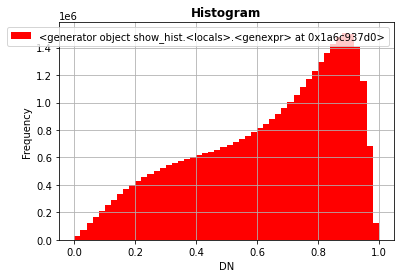

In [22]:
# histogram to make sure 0's were converted to NaN's
show_hist(cor_rast, bins = 50)

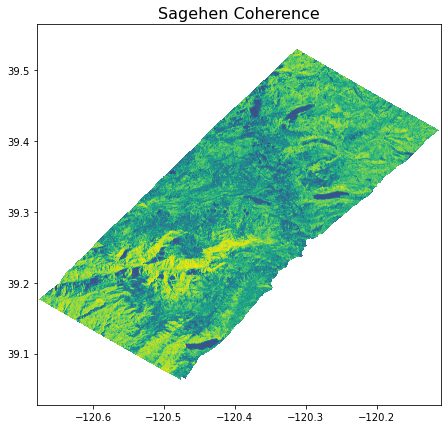

In [23]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Sagehen Coherence",fontsize = 16);
show((cor_rast, 1), cmap = 'viridis'); # info from histogram

# DL/Convert Single File using ```UavsarImage```
We just showed how to use ```UavsarImage```, which is for bulk zip file DL/conversion. Now we'll show ```UavsarImage```, which provides the same functionality for a single image and has native plotting utility.

/Users/jacktarricone/uavsar_pytools_jack/uavsar_pytools/UavsarImage.py:81: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if self.arr != None:


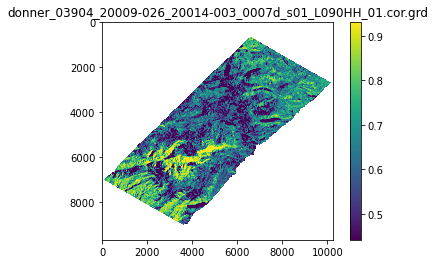

In [24]:
# define outpout dir and list files
os.chdir('/Users/jacktarricone/Desktop/zach_test/single/')
single_url = 'http://uavsar.asfdaac.alaska.edu/UA_donner_03904_20009-026_20014-003_0007d_s01_L090_01/donner_03904_20009-026_20014-003_0007d_s01_L090HH_01.cor.grd'
image = UavsarImage(url = single_url, work_dir = './data/imgs/')
image.url_to_tiff()
image.show()